### Import Packages

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import os

In [2]:
import collections

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Face Detection

### Prepare File

In [4]:
vid = "/content/drive/Shareddrives/20-2 ybigta project - 유튜브 썸네일 자동제작 프로그램/박재범 HL/HL_sample_4.mp4"

In [5]:
people = int(input("동영상에 등장하는 주요인물의 수는 몇 명인가요? : "))

동영상에 등장하는 주요인물의 수는 몇 명인가요? : 2


In [6]:
people

2

### Convert Video File to DataFrame

In [7]:
frames_raw = pd.DataFrame(columns=["frame","image"])

In [8]:
vidcap = cv2.VideoCapture(vid)
length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

count = 0
while(vidcap.isOpened()):
  ret, image = vidcap.read()
  # read()는 grab()와 retrieve() 두 함수를 한 함수로 불러옴
  # 두 함수를 동시에 불러오는 이유는 프레임이 존재하지 않을 때
  # grab() 함수를 이용하여 return false 혹은 NULL 값을 넘겨 주기 때문
  if (int(vidcap.get(1)) % 20 == 0):
    print("비디오 처리중 ...(",round(int(vidcap.get(1))/length*100),"%)")
    frames_raw = frames_raw.append({"frame": count,"image":cv2.cvtColor(image, cv2.COLOR_BGR2RGB)},ignore_index=True)  #frames_df에 프레임값과 image(RGB 순으로 변환) 추가
    count += 1
  elif ret is False:
    break
vidcap.release()

In [407]:
len(frames_raw)

0

### Face Detection for All Frames

In [408]:
frames_df= frames_raw.copy()
face_cascade = cv2.CascadeClassifier("/content/drive/MyDrive/thumbnail_generator/face_detection/haarcascade_frontalface_default.xml")

In [409]:
plt.imshow(frames_df.iloc[0,1])

IndexError: ignored

In [ ]:
plt.imshow(frames_df.iloc[1,1])

In [ ]:
height, width, channel = frames_df.iloc[0,1].shape

In [ ]:
clmn = ["image","face_check"]
size_clmn = []
for p in range(people):
  clmn.append("face_"+str(p+1))
  size_clmn.append("w_"+str(p+1))
  size_clmn.append("h_"+str(p+1))
face_df = pd.DataFrame(columns= clmn + size_clmn)

face_df

In [ ]:
clmn = ["image","face_check"]
size_clmn = []
for p in range(people):
  clmn.append("face_"+str(p+1))
  size_clmn.append("w_"+str(p+1))
  size_clmn.append("h_"+str(p+1))
face_df = pd.DataFrame(columns= clmn + size_clmn)

k = 0
for idx in range(len(frames_df)): #한 프레임 당 이미지, 얼굴인식
  print(idx)
  frm = frames_df.iloc[idx,0]
  im = frames_df.iloc[idx,1]
  im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
  face_im = im.copy()
  
  faces = face_cascade.detectMultiScale(im_gray, 1.3, 5) #얼굴 인식!
  
  if len(faces) == people : #face 인식 된 경우만
    new_face = {"image" : im}
    face_detected = 0

    for n_th in range(people): #사람별 이미지
        
        for (x,y,w,h) in [faces[n_th]]:
          print(x,y,w,h)
          if w!=0 and h!=0:
            x = max(round(x - w * 0.1) , 0)
            y = max(round(y - h * 0.3) , 0)
            w = round(w * 1.2)
            h = round(h * 1.4)

            new_face["w_"+str(n_th+1)] = w
            new_face["h_"+str(n_th+1)] = h
          
            cv2.rectangle(face_im,(x,y),(x+w,y+h),(255,0,0),2) # 원본 영상에 위치 표시
            roi_color = im[y:min(y+h,height), x:min(x+w,width)] # roi 
            new_face["face_" + str(n_th+1)] = roi_color
            face_detected += 1
            print("face:",face_detected)

    #한 프레임 다 끝나고      
    new_face["face_check"] = face_im
    
    if face_detected == people:
      k+=1
      print("success_",k)
      face_df = face_df.append(new_face,ignore_index=True)

face_raw = face_df.copy()

In [ ]:
len(face_df)

In [ ]:
face_df = face_raw.copy()

In [ ]:
face_df = face_raw.copy()
lst_w = []
lst_h = [] 
for i in range(len(size_clmn)):
  if i % 2 == 0:
    lst_w += list(face_df[size_clmn[i]])
  else:
    lst_h += list(face_df[size_clmn[i]])

for i in range(len(size_clmn)):
  if i % 2 == 0:
    avg = np.mean(lst_w)
    print(avg)
  else:
    avg = np.mean(lst_h) 
    print(avg)

  search_df = face_df[(face_df[size_clmn[i]] < (avg /1.5) ) | (face_df[size_clmn[i]] > (avg*2))]
  print(search_df.index)
  face_df.drop(list(search_df.index), axis=0,inplace = True)
  face_df.reset_index(drop=True, inplace=True)

In [ ]:
face_df = face_raw.copy()

for i in size_clmn:
  quartile_1 = face_raw[i].quantile(0.35)
  quartile_3 = face_raw[i].quantile(0.65)
  print(quartile_1,quartile_3)
  IQR = quartile_3 - quartile_1
  print(IQR)
  search_df = face_df[(face_df[i] < (quartile_1 - 1.5 * IQR)) | (face_df[i] > (quartile_3 + 1.5 * IQR))]
  print(search_df.index)
  face_df.drop(list(search_df.index), axis=0,inplace = True)
  face_df.reset_index(drop=True, inplace=True)

In [ ]:
len(face_df)

In [ ]:
plt.imshow(face_df.iloc[0,0]) #전체 이미지

In [ ]:
plt.imshow(face_df.iloc[0,1]) #얼굴영역 표시 이미지

In [ ]:
plt.imshow(face_df.iloc[0,2]) #첫번째 사람 얼굴

In [ ]:
plt.imshow(face_df.iloc[0,3]) #두번째 사람 얼굴

In [ ]:
plt.imshow(face_df.iloc[0,4]) 

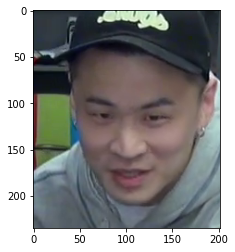

In [373]:
plt.imshow(face_df.iloc[0,5]) 

#Emotion Classifier

In [374]:
emotion_classifier = load_model('/content/drive/MyDrive/thumbnail_generator/face_detection/emotion_model.hdf5', compile=False)
EMOTIONS = ["Angry" ,"Disgusting","Fearful", "Happy", "Sad", "Surpring","Neutral"]

In [377]:
labels.count("Neutral")

3

In [380]:
avg_list = []
drop_list = []
for i in range(len(face_df)):
  emotion_n=0
  emotion_prob = 0
  emotion_lst = []
  labels = []
  print("turn:" ,i, "len:", len(face_df))
  for j in range(people):
    canvas = np.zeros((250, 300, 3), dtype="uint8")
    image = face_df.iloc[i,j+2]
    roi_gray =  cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    roi_gray = cv2.resize(roi_gray, (48, 48))
    roi_gray = roi_gray.astype("float") / 255.0
    roi_gray = img_to_array(roi_gray)
    roi_gray = np.expand_dims(roi_gray, axis=0)

    preds = emotion_classifier.predict(roi_gray)[0]
    emotion_probability = np.max(preds)
    emotion_lst.append(emotion_probability)

    if emotion_probability>0:
      emotion_n += 1
      emotion_prob += emotion_probability
      labels.append(EMOTIONS[preds.argmax()])
  
  cnt = collections.Counter(labels)
  if (emotion_n == people) and (labels.count("Neutral") <= len(labels)/2):
    avg_list.append( (emotion_prob / emotion_n) )
    print(avg_list)
    #avg_list.append(np.manx(emotion_lst))
    
  else:
    drop_list.append(i)

face_df.drop(drop_list,inplace=True)
face_df.reset_index(drop=True,inplace=True)
final_df = face_df.copy()
final_df["emotion_avg"] = avg_list

turn: 0 len: 22
[0.6573380529880524]
turn: 1 len: 22
[0.6573380529880524, 0.6140411868691444]
turn: 2 len: 22
[0.6573380529880524, 0.6140411868691444, 0.5184985473752022]
turn: 3 len: 22
[0.6573380529880524, 0.6140411868691444, 0.5184985473752022, 0.46519310772418976]
turn: 4 len: 22
[0.6573380529880524, 0.6140411868691444, 0.5184985473752022, 0.46519310772418976, 0.529181644320488]
turn: 5 len: 22
[0.6573380529880524, 0.6140411868691444, 0.5184985473752022, 0.46519310772418976, 0.529181644320488, 0.6062350943684578]
turn: 6 len: 22
[0.6573380529880524, 0.6140411868691444, 0.5184985473752022, 0.46519310772418976, 0.529181644320488, 0.6062350943684578, 0.6159661933779716]
turn: 7 len: 22
turn: 8 len: 22
turn: 9 len: 22
turn: 10 len: 22
turn: 11 len: 22
turn: 12 len: 22
turn: 13 len: 22
turn: 14 len: 22
turn: 15 len: 22
turn: 16 len: 22
turn: 17 len: 22
turn: 18 len: 22
turn: 19 len: 22
turn: 20 len: 22
turn: 21 len: 22


In [381]:
len(final_df)

7

In [382]:
drop_list

[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [383]:
final_df.sort_values(by= "emotion_avg", inplace = True,ascending=False,ignore_index=True)

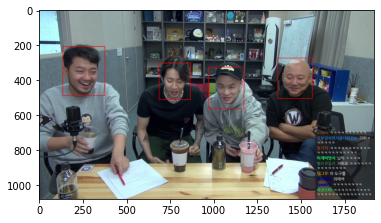

In [384]:
plt.imshow(final_df.iloc[0,1])

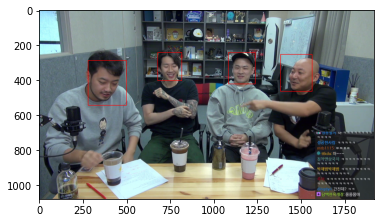

In [385]:
plt.imshow(final_df.iloc[1,1])

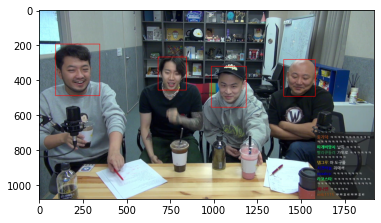

In [386]:
plt.imshow(final_df.iloc[2,1])

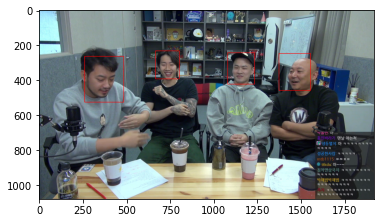

In [387]:
plt.imshow(final_df.iloc[3,1])

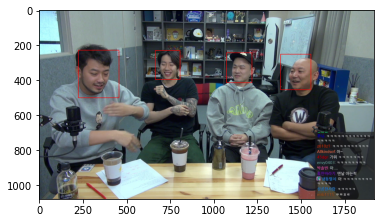

In [388]:
plt.imshow(final_df.iloc[4,1])

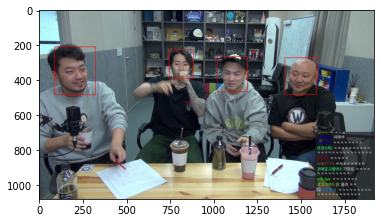

In [389]:
plt.imshow(final_df.iloc[5,1])

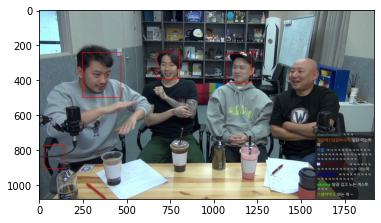

In [390]:
plt.imshow(final_df.iloc[6,1])

In [391]:
plt.imshow(final_df.iloc[7,1])

IndexError: ignored

In [ ]:
plt.imshow(final_df.iloc[8,1])

In [ ]:
plt.imshow(final_df.iloc[9,1])

In [ ]:
plt.imshow(final_df.iloc[10,1])

In [392]:
save_i = "_박재범(5)"

In [393]:
a_directory = "/content/drive/MyDrive/thumbnail_generator/sample" + str(save_i) + "/전체화면"
b_directory = "/content/drive/MyDrive/thumbnail_generator/sample" + str(save_i) + "/얼굴별"

if not os.path.exists(a_directory):
  os.makedirs(a_directory)

if not os.path.exists(b_directory):
  os.makedirs(b_directory)

In [400]:
np.min(l)

7

In [401]:
l =[len(final_df),10]
for i in range(np.min(l)):
  try:
    cv2.imwrite(a_directory+"/"+str(i)+".jpg",cv2.cvtColor(final_df.iloc[i,0], cv2.COLOR_BGR2RGB))
  
    for j in range(people):
      try:
        b_directory = "/content/drive/MyDrive/thumbnail_generator/sample" + str(save_i) + "/얼굴별/"
        cv2.imwrite(b_directory+str(i)+"_"+str(j)+".jpg",cv2.cvtColor(final_df.iloc[i,j+2], cv2.COLOR_BGR2RGB))
      except:
        print("!")
  except:
    print("!")